In [1]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from peakdetect import peakdetect
from scipy.ndimage.interpolation import shift
%matplotlib inline

In [2]:
engine = create_engine('sqlite+pysqlite:///../SQL/72_8.db')

In [3]:
import time
start_time = time.time()
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
Hitdf = pd.io.sql.read_sql("SELECT * FROM Hit", engine)
PSAdf = pd.io.sql.read_sql("SELECT * FROM PSA", engine)
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
#RawADCdf = pd.io.sql.read_sql("SELECT * FROM RawADC", engine)
end_time = time.time()
print end_time-start_time

483.491911888


In [4]:
def Process(Event):
    mesh = Event.iloc[:,3:][Event.iloc[:,3:]>20].sum(axis=0)
    #print mesh
    return mesh
start_time = time.time()
mesh_df = ADCdf.groupby('EventID').apply(Process)
end_time = time.time()
print end_time-start_time

8.06070995331


In [5]:
def convolve(event):
    mesh_convol = np.convolve(event.values,([1]*10)[::-1],'same')
    return pd.Series(mesh_convol,index=['t'+str(i) for i in range(512)])
convol_df=mesh_df.apply(convolve,axis=1)
convol_df.reset_index(inplace=True)

In [6]:
status_df = pd.read_csv("72_8_t0.csv")
status_df.columns = ['EventID','trigger']

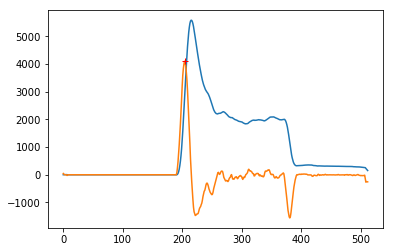

In [7]:
grad = np.gradient(convol_df.iloc[0].values)
peaks = peakdetect(grad,lookahead=10,delta=10)
pl = peaks[1]+peaks[0]
mp = max(np.abs(zip(*pl)[1]))
pl = [(x,y) for x,y in pl if abs(y)>0.08*mp and y>0]
plt.plot(convol_df.iloc[0].values*0.1)
plt.plot(grad)
plt.plot(zip(*pl)[0],zip(*pl)[1],'+',c='r')

(50, 400)

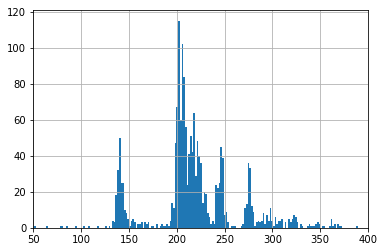

In [8]:
def FindLeadingEdge(e):
    
    event= e.iloc[1:-1]
    grad = np.gradient(event.values)
    peaks = peakdetect(grad,lookahead=10,delta=10)
    pl = peaks[1]+peaks[0]
    pl = [(x,y) for x,y in pl if x>30 and x<500]
    mp = max(zip(*pl)[1])
    pl = [(x,y) for x,y in pl if abs(y)>0.5*mp]
    pp = sorted(pl,key=lambda x:x[1])[-1]
    #print e[['EventID','trigger']].values.tolist() +list(pp)
    tmp = e[['EventID','trigger']].values.tolist() +list(pp)
    return pd.Series(tmp,index=['EventID','trigger','pos','height'])

    
tmp_df = pd.merge(convol_df,status_df,on='EventID')
tmp_df = tmp_df[~tmp_df['trigger'].isnull()]
tmp_df = tmp_df[tmp_df['trigger']<425]
peakdf = tmp_df.apply(FindLeadingEdge,axis=1)
peakdf['pos'].hist(bins=200)
#(peakdf['trigger']-peakdf['pos']).hist(bins=np.linspace(150,200,100))
#(peakdf['pos']).hist(bins=np.linspace(180,240,60))
plt.xlim([50,400])

(0, 70000)

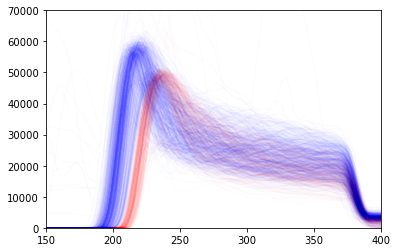

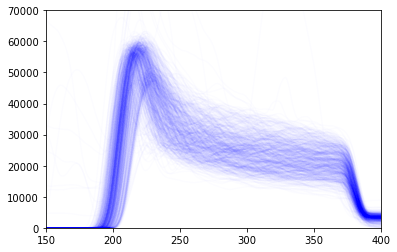

In [9]:
tmpdf = convol_df.iloc[peakdf[(peakdf['pos']>215)&((peakdf['pos']<225))]['EventID'].values.astype(int).tolist()]
plt.plot(tmpdf.iloc[:,1:].T.values,c=(1,0,0,0.01));
tmpdf = convol_df.iloc[peakdf[(peakdf['pos']>190)&((peakdf['pos']<215))]['EventID'].values.astype(int).tolist()]
plt.plot(tmpdf.iloc[:,1:].T.values,c=(0,0,1,0.01));
plt.xlim([150,400])
plt.ylim([0,70000])
plt.figure()
tmpdf = convol_df.iloc[peakdf[(peakdf['pos']>190)&((peakdf['pos']<215))]['EventID'].values.astype(int).tolist()]
plt.plot(tmpdf.iloc[:,1:].T.values,c=(0,0,1,0.01));
plt.xlim([150,400])
plt.ylim([0,70000])
#plt.xlim([350,400])
#plt.ylim([0,40000])

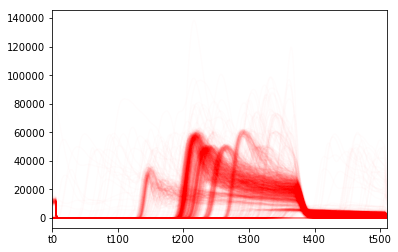

In [10]:
convol_df.iloc[:,1:].T.plot(c=(1,0,0,0.01),legend=False)
#plt.xlim([350,400])
#plt.ylim([0,40000])
#plt.xlim([150,250])
#plt.ylim([0,60000])

In [3]:
def Shift(r):
    r1 = r.copy()
    r1.iloc[1:-1] = r1.iloc[1:-1].shift(int(380-r1['trigger']))
    return  r1.fillna(0)
tmp_df = pd.merge(convol_df,status_df,on='EventID')
tmp_df = tmp_df[~(tmp_df['trigger'].isnull())]
tmp1_df = tmp_df.apply(Shift,axis=1)
tmp1_df.iloc[1:-1].T.plot(c=(1,0,0,0.01),legend=None)
#plt.xlim([150,250])
#plt.ylim([0,60000])

NameError: name 'pd' is not defined

In [2]:
tmp1_df = tmp1_df[~tmp1_df['trigger'].isnull()]
tmp1_df = tmp1_df[(tmp1_df['trigger']<425)&(tmp1_df['trigger']>340)]
peakdf = tmp1_df.apply(FindLeadingEdge,axis=1)
#(peakdf['trigger']-peakdf['pos']).hist(bins=np.linspace(150,200,100))
peakdf['pos'].hist(bins=200)
#peakdf['pos'].hist(bins=np.linspace(180,280,100))
plt.xlim([50,400])

NameError: name 'tmp1_df' is not defined

(0, 70000)

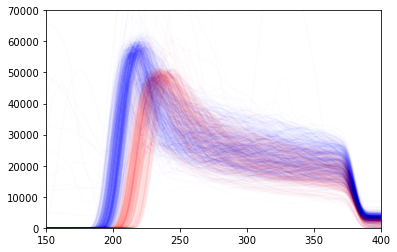

In [13]:
tmpdf = tmp1_df.ix[peakdf[(peakdf['pos']>211)&((peakdf['pos']<230))]['EventID'].values.astype(int).tolist()]
plt.plot(tmpdf.iloc[:,1:].T.values,c=(1,0,0,0.01));
tmpdf = tmp1_df.ix[peakdf[(peakdf['pos']>190)&((peakdf['pos']<211))]['EventID'].values.astype(int).tolist()]
plt.plot(tmpdf.iloc[:,1:].T.values,c=(0,0,1,0.01));
plt.xlim([150,400])
plt.ylim([0,70000])

In [1]:
tmpdf = tmp1_df.ix[peakdf[(peakdf['pos']>211)&((peakdf['pos']<230))]['EventID'].values.astype(int).tolist()]
plt.plot(tmpdf.iloc[:,1:].T.values,c=(1,0,0,0.01));


NameError: name 'tmp1_df' is not defined

(493, 396)

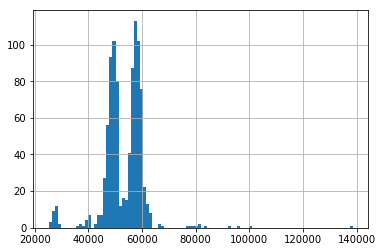

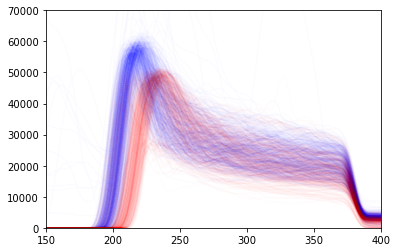

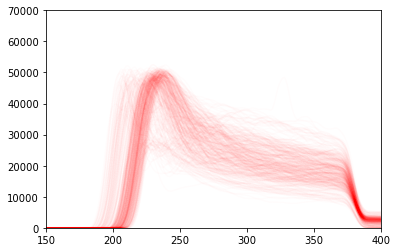

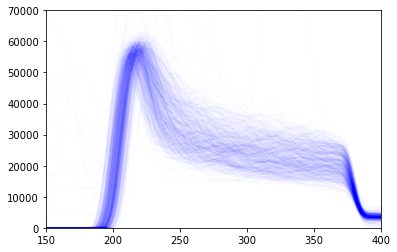

In [14]:
tmp = tmp1_df.ix[peakdf[(peakdf['pos']>190)&((peakdf['pos']<225))]['EventID']]
heights = tmp.iloc[:,1:-1].max(axis=1)
heights.hist(bins=100)
#tmp[heights<52500].iloc[:,1:-1]
#tmp[heights<52500].iloc[:,1:-1].T.plot(legend=None)
plt.figure()
plt.plot(tmp[heights>52500].iloc[:,1:-1].T.values,c=(0,0,1,0.01));
plt.plot(tmp[heights<52500].iloc[:,1:-1].T.values,c=(1,0,0,0.01));
plt.xlim([150,400])
plt.ylim([0,70000])
plt.figure()
plt.plot(tmp[heights<52500].iloc[:,1:-1].T.values,c=(1,0,0,0.01));
plt.xlim([150,400])
plt.ylim([0,70000])
plt.figure()
plt.plot(tmp[heights>52500].iloc[:,1:-1].T.values,c=(0,0,1,0.01));
plt.xlim([150,400])
plt.ylim([0,70000])

sum((heights>52500)&(heights<70000)),sum((heights<52500)&(heights>40000))

(200, 300)

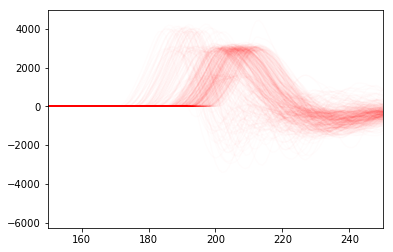

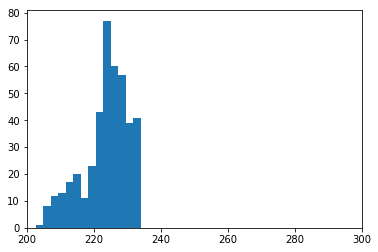

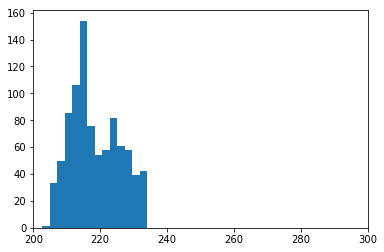

In [15]:
grad = np.gradient(tmp[heights<52500].iloc[:,1:-1],axis=1)
plt.plot(grad[:,10:-10].T,c=(1,0,0,0.01));
plt.xlim([150,250])
plt.figure()
plt.hist(np.argmax(grad,axis=1)+10,bins=100);
plt.xlim([200,300])
grad = np.gradient(tmp.iloc[:,1:-1],axis=1)

plt.figure()
plt.hist(np.argmax(grad,axis=1)+10,bins=100);
plt.xlim([200,300])
